# Project: Airbnb Boston Demand Side

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This notebook will examine Airbnb Listings from a demand perspective. We will look at average price by neighborhood controlling for seasonality and day of week. The goal of this investigation will be to identify good deals for a potential trip to boston :).

In [3]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import datetime
import seaborn as sns
from shapely.geometry import Point, Polygon
import geopandas as gpd
import descartes
from mpl_toolkits.axes_grid1 import make_axes_locatable


%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [4]:
#read in data
df_boston_calendar = pd.read_csv('boston-airbnb-open-data/calendar.csv')
df_boston_listings = pd.read_csv('boston-airbnb-open-data/listings.csv')
df_boston_reviews = pd.read_csv('boston-airbnb-open-data/reviews.csv')
df_boston_neighborhoods = pd.read_csv('boston-airbnb-open-data/neighbourhoods.csv')

# Getting map data for geopandas plots
boston_street_map = gpd.read_file('boston-airbnb-open-data/neighbourhoods.geojson')



In [5]:
df_boston_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [6]:
df_boston_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [7]:
df_boston_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [8]:
df_boston_neighborhoods.head()

,neighbourhood_group,neighbourhood
0,NaN,Allston
1,NaN,Back Bay
2,NaN,Bay Village
3,NaN,Beacon Hill
4,NaN,Brighton


In [9]:
df_boston_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

In [10]:
df_boston_listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,calculated_host_listings_count,reviews_per_month
count,3.585000e+03,3.585000e+03,3.585000e+03,3585.000000,3585.000000,0.0,3585.000000,3585.000000,3585.000000,3571.000000,...,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000,0.0,0.0,3585.000000,2829.000000
mean,8.440875e+06,2.016091e+13,2.492311e+07,58.902371,58.902371,NaN,42.340032,-71.084818,3.041283,1.221647,...,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,NaN,NaN,12.733891,1.970908
std,4.500787e+06,8.516813e-01,2.292781e+07,171.119663,171.119663,NaN,0.024403,0.031565,1.778929,0.501487,...,0.931863,1.168977,0.762753,0.735507,0.903436,1.011116,NaN,NaN,29.415076,2.120561
min,3.353000e+03,2.016091e+13,4.240000e+03,0.000000,0.000000,NaN,42.235942,-71.171789,1.000000,0.000000,...,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,NaN,NaN,1.000000,0.010000
25%,4.679319e+06,2.016091e+13,6.103425e+06,1.000000,1.000000,NaN,42.329995,-71.105083,2.000000,1.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,NaN,NaN,1.000000,0.480000
50%,8.577620e+06,2.016091e+13,1.928100e+07,2.000000,2.000000,NaN,42.345201,-71.078429,2.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,NaN,2.000000,1.170000
75%,1.278953e+07,2.016091e+13,3.622147e+07,7.000000,7.000000,NaN,42.354685,-71.062155,4.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,6.000000,2.720000
max,1.493346e+07,2.016091e+13,9.385411e+07,749.000000,749.000000,NaN,42.389982,-71.000100,16.000000,6.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,136.000000,19.150000


In [11]:
df_boston_listings.shape

(3585, 95)

In [13]:
df_boston_listings.smart_location

0           Boston, MA
1           Boston, MA
2           Boston, MA
3           Boston, MA
4           Boston, MA
             ...      
3580    Somerville, MA
3581     Brookline, MA
3582     Cambridge, MA
3583    Somerville, MA
3584    Somerville, MA
Name: smart_location, Length: 3585, dtype: object

In [14]:
df_boston_reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [15]:
df_boston_reviews.groupby('listing_id').id.count().sort_values(ascending = False).head()

listing_id
66288      404
1497879    320
414419     312
31796      291
916123     281
Name: id, dtype: int64

In [16]:
df_boston_listings.reviews_per_month.sort_values(ascending = False).head()

1627    19.15
1630    16.30
1546    15.54
1560    15.00
1543    14.34
Name: reviews_per_month, dtype: float64

In [17]:
df_boston_reviews.groupby('date').id.count().sort_values(ascending = False).head()

date
2016-04-19    342
2016-08-08    315
2016-08-14    289
2016-07-21    268
2016-06-05    266
Name: id, dtype: int64

In [18]:
def date_strip(date):
    """Take in a sting that is a date and return month"""
    date_date = datetime.datetime.strptime(date, "%Y-%m-%d")
    return date_date.month

In [19]:
df_boston_reviews['month'] = df_boston_reviews.date.apply(date_strip)

In [20]:
df_boston_reviews.groupby('month').id.count().sort_values(ascending = False).head()

month
8    10345
7     9333
6     8369
5     8115
4     6116
Name: id, dtype: int64

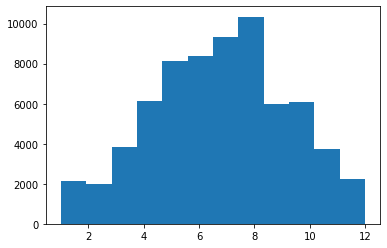

In [21]:
# using reviews as a proxy for demand, lets see when boston is the most popular
plt.hist(df_boston_reviews.month, bins =12);

In [22]:
df_boston_listings.iloc[0]

id                                                               12147973
listing_url                         https://www.airbnb.com/rooms/12147973
scrape_id                                                  20160906204935
last_scraped                                                   2016-09-07
name                                           Sunny Bungalow in the City
                                                    ...                  
cancellation_policy                                              moderate
require_guest_profile_picture                                           f
require_guest_phone_verification                                        f
calculated_host_listings_count                                          1
reviews_per_month                                                     NaN
Name: 0, Length: 95, dtype: object

In [23]:
(df_boston_listings.isnull().sum(axis = 1)/df_boston_listings.shape[1]).sort_values(ascending = False) 

3300    0.368421
1923    0.357895
1836    0.357895
3223    0.347368
2057    0.336842
          ...   
2979    0.052632
3219    0.042105
2047    0.042105
446     0.042105
47      0.042105
Length: 3585, dtype: float64

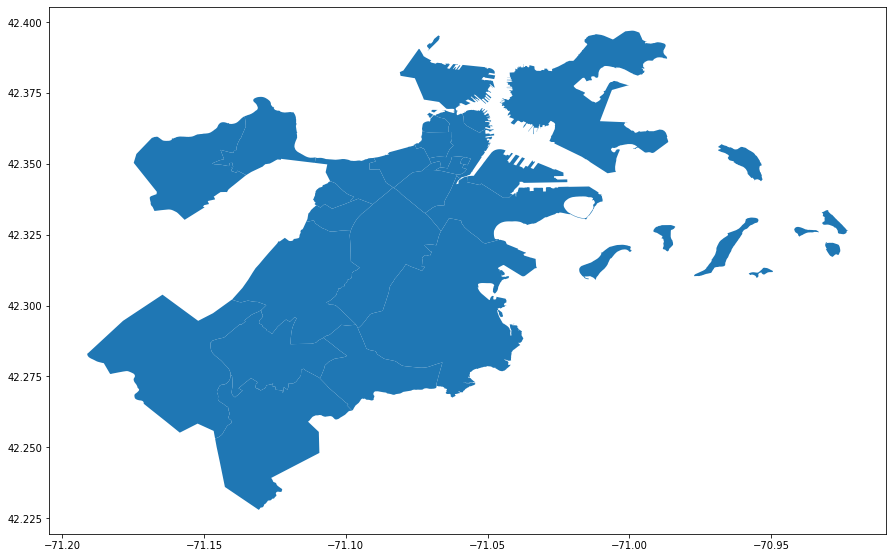

In [24]:
#practice plot of map
fig,ax = plt.subplots(figsize = (15,15))
boston_street_map.plot(ax = ax);

### Data Cleaning

In [25]:
# create point geometry for plotting 
geometry = [Point(xy) for xy in zip(df_boston_listings['longitude'],df_boston_listings['latitude'])]

crs = {'init': 'epsg:2249'}

In [26]:
# clean price to get it into a useable format
df_boston_listings['price'] = df_boston_listings.price.apply(lambda x: float(x.strip("$").replace(',', '')))

<a id='eda'></a>
## Exploratory Data Analysis

In [27]:
# Create Geospacial Dataframe to allow for plotting of information by location
gpd_df = gpd.GeoDataFrame(df_boston_listings,
                         crs = crs,
                         geometry = geometry)
gpd_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,geometry
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,f,NaN,NaN,f,moderate,f,f,1,NaN,POINT (-71.13306792912681 42.28261879577949)
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,f,NaN,NaN,t,moderate,f,f,1,1.30,POINT (-71.13437396457161 42.28624082186742)
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,f,NaN,NaN,f,moderate,t,f,1,0.47,POINT (-71.13576525374667 42.29243788665679)
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,f,NaN,NaN,f,moderate,f,f,1,1.00,POINT (-71.12102117350554 42.28110618827365)
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,f,NaN,NaN,f,flexible,f,f,1,2.25,POINT (-71.1362580468337 42.28451220982457)


In [28]:
gpd_df.drop(['name', 'thumbnail_url', 'medium_url' ,'experiences_offered' ,'summary', 'space', 'description', 'listing_url', 'scrape_id', 'last_scraped', 'access', 'transit', 'interaction'], axis = 1, inplace = True)

In [29]:
gpd_df.head()

,id,neighborhood_overview,notes,house_rules,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,geometry
0,12147973,"Roslindale is quiet, convenient and friendly. ...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,...,f,NaN,NaN,f,moderate,f,f,1,NaN,POINT (-71.13306792912681 42.28261879577949)
1,3075044,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,...,f,NaN,NaN,t,moderate,f,f,1,1.30,POINT (-71.13437396457161 42.28624082186742)
2,6976,The LOCATION: Roslindale is a safe and diverse...,I am in a scenic part of Boston with a couple ...,"I encourage you to use my kitchen, cooking and...",https://a2.muscache.com/im/pictures/6ae8335d-9...,https://a2.muscache.com/im/pictures/6ae8335d-9...,16701,https://www.airbnb.com/users/show/16701,Phil,2009-05-11,...,f,NaN,NaN,f,moderate,t,f,1,0.47,POINT (-71.13576525374667 42.29243788665679)
3,1436513,Roslindale is a lovely little neighborhood loc...,Please be mindful of the property as it is old...,- The bathroom and house are shared so please ...,https://a2.muscache.com/im/pictures/39764190-1...,https://a2.muscache.com/im/pictures/39764190-1...,6031442,https://www.airbnb.com/users/show/6031442,Meghna,2013-04-21,...,f,NaN,NaN,f,moderate,f,f,1,1.00,POINT (-71.12102117350554 42.28110618827365)
4,7651065,"I love the proximity to downtown, the neighbor...",I have one roommate who lives on the lower lev...,"Please no smoking in the house, porch or on th...",https://a1.muscache.com/im/pictures/97154760/8...,https://a1.muscache.com/im/pictures/97154760/8...,15396970,https://www.airbnb.com/users/show/15396970,Linda,2014-05-11,...,f,NaN,NaN,f,flexible,f,f,1,2.25,POINT (-71.1362580468337 42.28451220982457)


### Are there any hidden gems that have a high quality per USD? 

#### Average price per neighborhood?

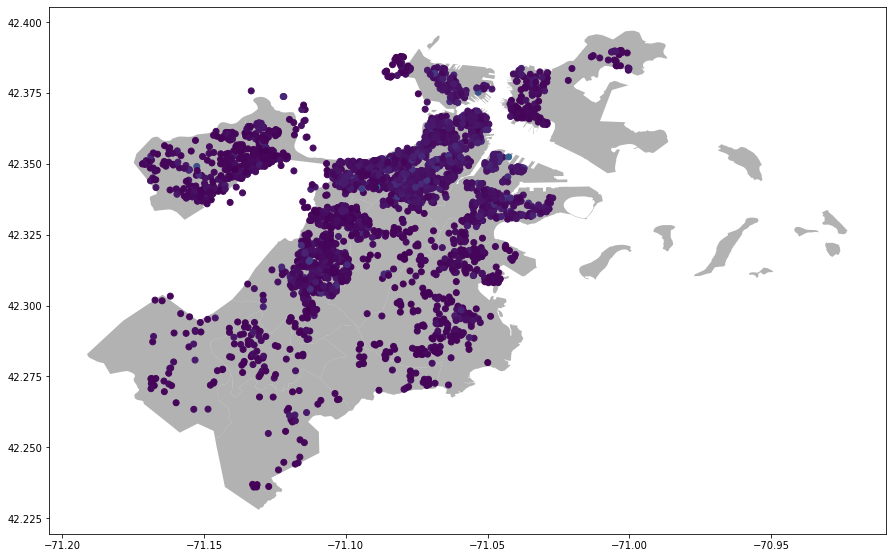

In [30]:
fig,ax = plt.subplots(figsize = (15,15))
boston_street_map.plot(ax = ax, alpha = 0.6, color = 'grey')
gpd_df.plot(ax = ax, column = 'price');

In [31]:
boston_street_map.head()

,neighbourhood,neighbourhood_group,geometry
0,Roslindale,None,"(POLYGON ((-71.125927 42.272004, -71.125747 42..."
1,Jamaica Plain,None,"(POLYGON ((-71.104992 42.326093, -71.104879 42..."
2,Mission Hill,None,"(POLYGON ((-71.090434 42.335761, -71.092753 42..."
3,Longwood Medical Area,None,"(POLYGON ((-71.098108 42.336722, -71.098923 42..."
4,Bay Village,None,"(POLYGON ((-71.06662900000001 42.348774, -71.0..."


In [32]:
temp = gpd_df.groupby('neighbourhood').price.mean()
merged = boston_street_map.merge(temp, how = 'left', on = 'neighbourhood')
merged.columns

Index(['neighbourhood', 'neighbourhood_group', 'geometry', 'price'], dtype='object')

/Users/cjorg/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


''

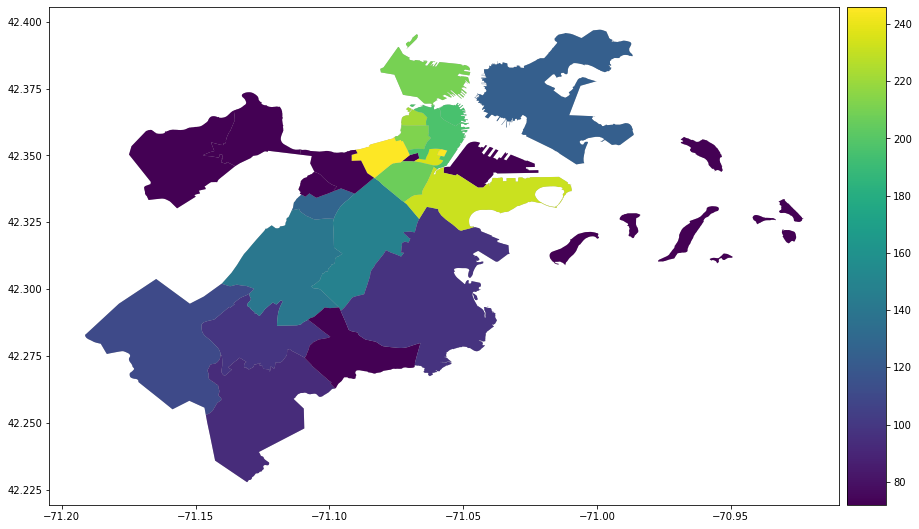

In [33]:
fig,ax = plt.subplots(figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
boston_street_map.plot(ax = ax, alpha = 0.6, color = 'grey')
merged.plot(ax = ax, column = 'price', legend = True, cax = cax)
;


Looks like most of the northern part of boston is ver expensive while the southern parts tend to be cheaper.

#### Average occupancy by neighborhood?


In [34]:
temp = df_boston_reviews.drop(['date', 'reviewer_id', 'reviewer_name', 'comments', 'id'], axis = 1)
temp2 = df_boston_listings
merged = temp2.merge(temp, how = 'left', left_on= 'id', right_on = 'listing_id')
merged.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,geometry,listing_id,month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,moderate,f,f,1,NaN,POINT (-71.13306792912681 42.28261879577949),NaN,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,NaN,t,moderate,f,f,1,1.3,POINT (-71.13437396457161 42.28624082186742),3075044.0,6.0
2,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,NaN,t,moderate,f,f,1,1.3,POINT (-71.13437396457161 42.28624082186742),3075044.0,6.0
3,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,NaN,t,moderate,f,f,1,1.3,POINT (-71.13437396457161 42.28624082186742),3075044.0,6.0
4,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,NaN,t,moderate,f,f,1,1.3,POINT (-71.13437396457161 42.28624082186742),3075044.0,9.0


In [35]:
ave_reviews = merged.groupby('neighbourhood').id.count()/ merged.groupby('neighbourhood').id.nunique()

In [36]:
temp = ave_reviews
merged = boston_street_map.merge(temp, how = 'left', on = 'neighbourhood')
merged.columns

Index(['neighbourhood', 'neighbourhood_group', 'geometry', 'id'], dtype='object')

''

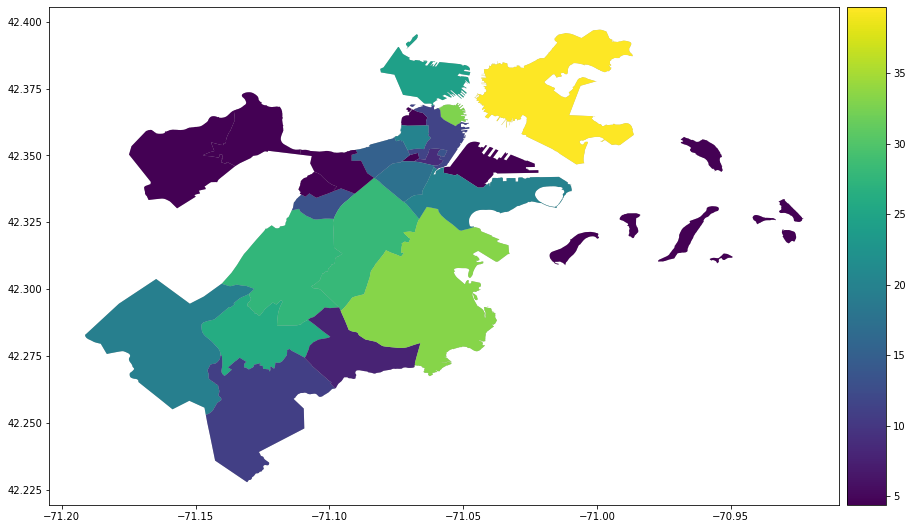

In [37]:
fig,ax = plt.subplots(figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
boston_street_map.plot(ax = ax, alpha = 0.6, color = 'grey')
merged.plot(ax = ax, column = 'id', legend = True, cax = cax)
;


Those more expensive areas have a lower utilization than the areas just around them indicating people are staying just outside of the expensive areas.

#### Average rating by neighborhood?


In [40]:
ratings = gpd_df.groupby('neighbourhood').review_scores_rating.mean()

In [41]:
temp = ratings
merged = boston_street_map.merge(temp, how = 'left', on = 'neighbourhood')
merged.columns

Index(['neighbourhood', 'neighbourhood_group', 'geometry',
       'review_scores_rating'],
      dtype='object')

''

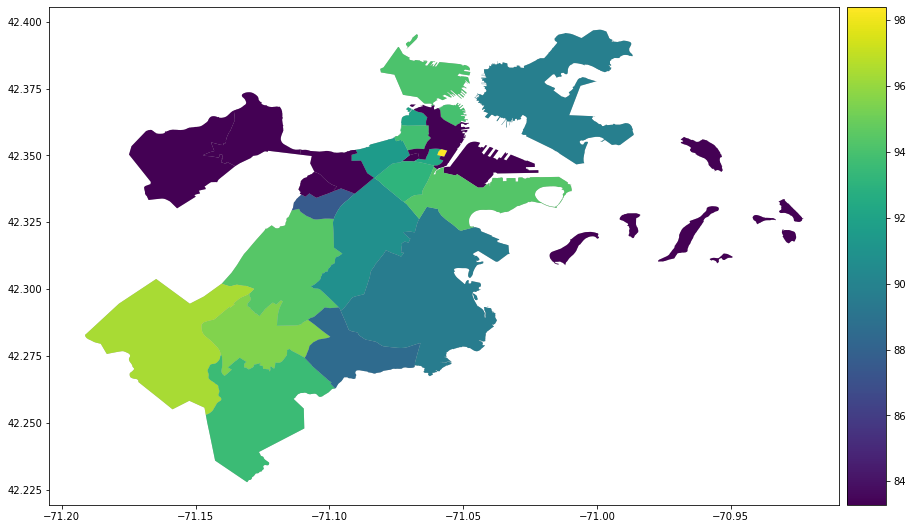

In [43]:
fig,ax = plt.subplots(figsize = (15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
boston_street_map.plot(ax = ax, alpha = 0.6, color = 'grey')
merged.plot(ax = ax, column = 'review_scores_rating', legend = True, cax = cax)
;

#### Conclusions
> It looks like the Roxbury or Mid Dorchester would be ideal neighborhoods to stay in based on the cheaper price they provide, high utilization and solid ratings.